In [ ]:
# DPB-Bert

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def scale_data(train_data, test_data):
    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    return pd.DataFrame(scaled_train_data, columns=train_data.columns), pd.DataFrame(scaled_test_data, columns=test_data.columns)
 
def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc=False):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=10, return_train_score=True)
    grid_search.fit(X_train, y_train)
 
    best_model = grid_search.best_estimator_
 
    print(f"\nResults for {model.__class__.__name__} - Cross Validation:")
    mean_fpr = np.linspace(0, 1, 100)
    tpr_list = []
    mean_accuracy_list = []
 
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
 
        fold_model = model.__class__(**best_model.get_params())
        fold_model.fit(X_train_fold, y_train_fold)
        predictions = fold_model.predict(X_val_fold)
 
        fpr, tpr, _ = roc_curve(y_val_fold, fold_model.predict_proba(X_val_fold)[:, 1])
        roc_auc = auc(fpr, tpr)
 
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Fold {fold} (AUC = {roc_auc:.2f})')

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tpr_list.append(interp_tpr)
        
        fold_accuracy = accuracy_score(y_val_fold, predictions)
        print(f"\nFold {fold} Accuracy: {fold_accuracy}")
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val_fold, predictions))
        mean_accuracy_list.append(fold_accuracy)
 
    mean_tpr = np.mean(tpr_list, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)
 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model.__class__.__name__} (Cross Validation)')
    plt.legend(loc='lower right')
 
    #if save_auroc:
     #   plt.savefig(f"{model.__class__.__name__}_CrossValidation_ROC.pdf")
    plt.show()
    plt.close()
 
    predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, predictions)
    test_roc_auc = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
 
    print("\nResults for", model.__class__.__name__, "- Testing:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("\nClassification Report:\n", classification_report(y_test, predictions))
 
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    print("Precision for Class 0:", precision[0])
    print("Recall for Class 0:", recall[0])
    print("F1-Score for Class 0:", f1[0])
 
    print("Precision for Class 1:", precision[1])
    print("Recall for Class 1:", recall[1])
    print("F1-Score for Class 1:", f1[1])
 
    print("\nMatthews Correlation Coefficient:", matthews_corrcoef(y_test, predictions))
    print("\nTest AUC Score:", auc(test_roc_auc[0], test_roc_auc[1]))


In [3]:
def svm_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.01, 0.1, 1, 10, 100, 1000]
    }
 
    svm_model = SVC(probability=True)
    train_and_evaluate(svm_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [4]:
def random_forest_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8, 16, 20]
    }
 
    rf_model = RandomForestClassifier()
    train_and_evaluate(rf_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [5]:
def adaboost_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }
 
    adaboost_model = AdaBoostClassifier()
    train_and_evaluate(adaboost_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [6]:
def xgboost_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
 
    xgb_model = XGBClassifier()
    train_and_evaluate(xgb_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)

In [7]:
def extratrees_classifier(X_train, y_train, X_test, y_test, cv, save_auroc=False):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
 
    extratrees_model = ExtraTreesClassifier()
    train_and_evaluate(extratrees_model, param_grid, X_train, y_train, X_test, y_test, cv, save_auroc)


In [10]:
training_data = pd.read_csv("Protein_Bert/feature_train.csv", index_col=None)
testing_data = pd.read_csv("Protein_Bert/feature_test.csv", index_col=None)

In [15]:
label_data_train = pd.read_csv("df_train_feature_pb.csv", index_col=None)
label_data_test = pd.read_csv("df_test_feature_pb.csv", index_col=None)

In [11]:
training_data

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.208095,0.220136,-0.197749,-0.210119,-0.225618,-0.220520,-0.218668,-0.216284,0.202558,-0.212885,...,0.213570,-0.205959,0.218051,-0.216005,-0.214325,-0.200823,0.206391,0.209501,0.195413,-0.214074
1,-0.209904,0.222025,-0.199485,-0.211941,-0.227543,-0.222412,-0.220548,-0.218148,0.204329,-0.214726,...,0.215416,-0.207753,0.219927,-0.217867,-0.216176,-0.202581,0.208188,0.211319,0.197132,-0.215923
2,-0.210550,0.222705,-0.200102,-0.212592,-0.228237,-0.223093,-0.221223,-0.218817,0.204959,-0.215386,...,0.216077,-0.208393,0.220600,-0.218535,-0.216839,-0.203207,0.208829,0.211969,0.197742,-0.216585
3,-0.207671,0.219691,-0.197343,-0.209691,-0.225164,-0.220075,-0.218226,-0.215846,0.202144,-0.212453,...,0.213137,-0.205539,0.217610,-0.215567,-0.213890,-0.200411,0.205970,0.209074,0.195011,-0.213639
4,-0.208217,0.220262,-0.197866,-0.210241,-0.225746,-0.220647,-0.218794,-0.216409,0.202678,-0.213009,...,0.213694,-0.206080,0.218176,-0.216129,-0.214450,-0.200942,0.206512,0.209623,0.195529,-0.214197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,-0.207851,0.219878,-0.197517,-0.209872,-0.225354,-0.220262,-0.218412,-0.216031,0.202321,-0.212636,...,0.213320,-0.205718,0.217796,-0.215752,-0.214074,-0.200587,0.206149,0.209255,0.195183,-0.213823
2514,-0.209156,0.221244,-0.198767,-0.211187,-0.226747,-0.221630,-0.219771,-0.217377,0.203596,-0.213965,...,0.214653,-0.207011,0.219151,-0.217097,-0.215411,-0.201854,0.207445,0.210567,0.196421,-0.215158
2515,-0.207422,0.219431,-0.197104,-0.209440,-0.224898,-0.219814,-0.217967,-0.215589,0.201900,-0.212199,...,0.212882,-0.205292,0.217351,-0.215310,-0.213636,-0.200170,0.205722,0.208824,0.194774,-0.213384
2516,-0.209384,0.221483,-0.198985,-0.211417,-0.226991,-0.221869,-0.220009,-0.217613,0.203819,-0.214197,...,0.214886,-0.207237,0.219388,-0.217332,-0.215644,-0.202075,0.207671,0.210796,0.196637,-0.215392


In [12]:
testing_data

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.208924,0.221001,-0.198544,-0.210953,-0.226499,-0.221386,-0.219529,-0.217138,0.203369,-0.213728,...,0.214415,-0.206781,0.218910,-0.216857,-0.215173,-0.201629,0.207214,0.210334,0.196201,-0.214920
1,-0.213070,0.225345,-0.202516,-0.215133,-0.230930,-0.225736,-0.223849,-0.221419,0.207424,-0.217954,...,0.218653,-0.210892,0.223220,-0.221134,-0.219422,-0.205653,0.211332,0.214504,0.200133,-0.219166
2,-0.207403,0.219411,-0.197085,-0.209421,-0.224878,-0.219794,-0.217947,-0.215570,0.201881,-0.212180,...,0.212863,-0.205273,0.217331,-0.215291,-0.213616,-0.200151,0.205703,0.208805,0.194756,-0.213365
3,-0.209905,0.222026,-0.199486,-0.211942,-0.227543,-0.222412,-0.220548,-0.218149,0.204330,-0.214727,...,0.215417,-0.207754,0.219927,-0.217867,-0.216177,-0.202582,0.208189,0.211320,0.197134,-0.215923
4,-0.208271,0.220318,-0.197919,-0.210296,-0.225803,-0.220703,-0.218850,-0.216465,0.202732,-0.213064,...,0.213749,-0.206134,0.218232,-0.216185,-0.214505,-0.200995,0.206566,0.209678,0.195582,-0.214253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,-0.208886,0.220963,-0.198507,-0.210915,-0.226461,-0.221348,-0.219491,-0.217100,0.203332,-0.213690,...,0.214378,-0.206743,0.218872,-0.216819,-0.215135,-0.201591,0.207176,0.210296,0.196163,-0.214882
626,-0.204975,0.216869,-0.194760,-0.206974,-0.222286,-0.217249,-0.215419,-0.213064,0.199508,-0.209706,...,0.210383,-0.202866,0.214809,-0.212788,-0.211129,-0.197794,0.203293,0.206363,0.192453,-0.210880
627,-0.211655,0.223858,-0.201164,-0.213706,-0.229412,-0.224248,-0.222371,-0.219956,0.206042,-0.216511,...,0.217205,-0.209490,0.221746,-0.219672,-0.217970,-0.204282,0.209928,0.213080,0.198795,-0.217715
628,-0.208443,0.220498,-0.198082,-0.210468,-0.225987,-0.220883,-0.219029,-0.216642,0.202898,-0.213238,...,0.213924,-0.206304,0.218411,-0.216362,-0.214681,-0.201161,0.206736,0.209850,0.195743,-0.214428


In [17]:
# Separate features and labels
X_train_data = training_data
y_train_data = label_data_train['Label']
X_test_data = testing_data
y_test_data = label_data_test['Label']

In [18]:
scaled_X_train, scaled_X_test = scale_data(X_train_data, X_test_data)

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Results for RandomForestClassifier - Cross Validation:

Fold 1 Accuracy: 0.5218253968253969

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.66      0.58       252
           1       0.53      0.38      0.45       252

    accuracy                           0.52       504
   macro avg       0.52      0.52      0.51       504
weighted avg       0.52      0.52      0.51       504


Fold 2 Accuracy: 0.5178571428571429

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.63      0.57       252
           1       0.52      0.40      0.45       252

    accuracy                           0.52       504
   macro avg       0.52      0.52      0.51       504
weighted avg       0.52      0.52      0.51       504


Fold 3 Accuracy: 0.5198412698412699

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.52     

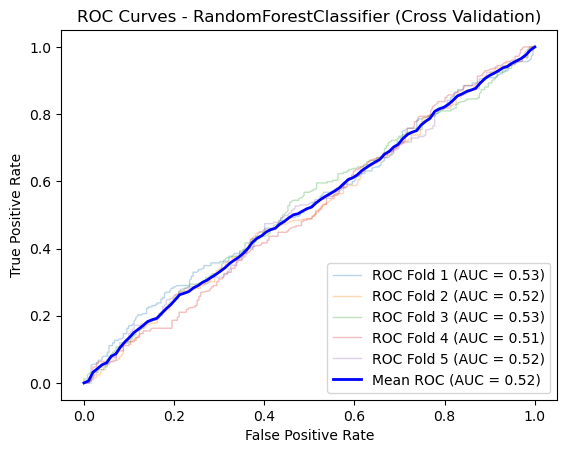


Results for RandomForestClassifier - Testing:
Accuracy: 0.5936507936507937

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.61       315
           1       0.60      0.55      0.57       315

    accuracy                           0.59       630
   macro avg       0.59      0.59      0.59       630
weighted avg       0.59      0.59      0.59       630

Precision for Class 0: 0.5860058309037901
Recall for Class 0: 0.638095238095238
F1-Score for Class 0: 0.6109422492401215
Precision for Class 1: 0.6027874564459931
Recall for Class 1: 0.5492063492063493
F1-Score for Class 1: 0.5747508305647842

Matthews Correlation Coefficient: 0.18804595819240322

Test AUC Score: 0.6204736709498614


In [20]:
random_forest_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


Results for AdaBoostClassifier - Cross Validation:

Fold 1 Accuracy: 0.5575396825396826

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.56      0.56       252
           1       0.56      0.56      0.56       252

    accuracy                           0.56       504
   macro avg       0.56      0.56      0.56       504
weighted avg       0.56      0.56      0.56       504


Fold 2 Accuracy: 0.5158730158730159

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.62      0.56       252
           1       0.52      0.42      0.46       252

    accuracy                           0.52       504
   macro avg       0.52      0.52      0.51       504
weighted avg       0.52      0.52      0.51       504


Fold 3 Accuracy: 0.5376984126984127

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.7

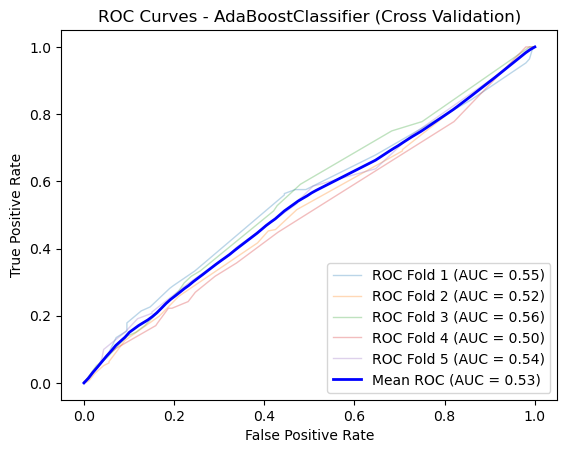


Results for AdaBoostClassifier - Testing:
Accuracy: 0.5888888888888889

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.53      0.56       315
           1       0.58      0.65      0.61       315

    accuracy                           0.59       630
   macro avg       0.59      0.59      0.59       630
weighted avg       0.59      0.59      0.59       630

Precision for Class 0: 0.6007194244604317
Recall for Class 0: 0.5301587301587302
F1-Score for Class 0: 0.563237774030354
Precision for Class 1: 0.5795454545454546
Recall for Class 1: 0.6476190476190476
F1-Score for Class 1: 0.6116941529235383

Matthews Correlation Coefficient: 0.17901700925064756

Test AUC Score: 0.6326379440665156


In [21]:
adaboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


Results for ExtraTreesClassifier - Cross Validation:

Fold 1 Accuracy: 0.5416666666666666

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.67      0.60       252
           1       0.56      0.41      0.47       252

    accuracy                           0.54       504
   macro avg       0.54      0.54      0.53       504
weighted avg       0.54      0.54      0.53       504


Fold 2 Accuracy: 0.5138888888888888

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.62      0.56       252
           1       0.52      0.40      0.45       252

    accuracy                           0.51       504
   macro avg       0.51      0.51      0.51       504
weighted avg       0.51      0.51      0.51       504


Fold 3 Accuracy: 0.5198412698412699

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.52      0

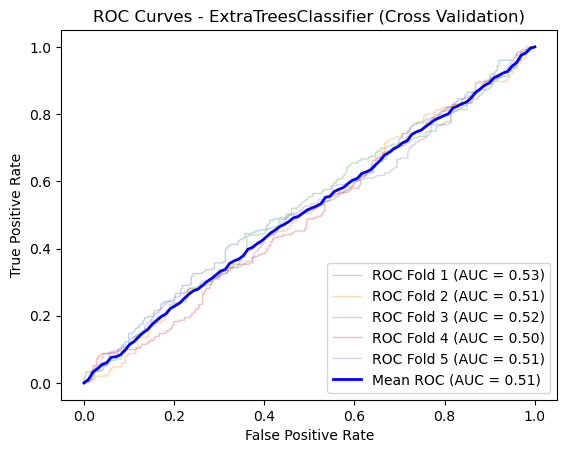


Results for ExtraTreesClassifier - Testing:
Accuracy: 0.580952380952381

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.59       315
           1       0.59      0.55      0.57       315

    accuracy                           0.58       630
   macro avg       0.58      0.58      0.58       630
weighted avg       0.58      0.58      0.58       630

Precision for Class 0: 0.5765765765765766
Recall for Class 0: 0.6095238095238096
F1-Score for Class 0: 0.5925925925925927
Precision for Class 1: 0.5858585858585859
Recall for Class 1: 0.5523809523809524
F1-Score for Class 1: 0.5686274509803921

Matthews Correlation Coefficient: 0.1621697453257737

Test AUC Score: 0.5816931216931217


In [22]:
extratrees_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

In [ ]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/zlei/.conda/envs/jupyter/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dty


Results for XGBClassifier - Cross Validation:

Fold 1 Accuracy: 0.5357142857142857

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.57      0.55       252
           1       0.54      0.50      0.52       252

    accuracy                           0.54       504
   macro avg       0.54      0.54      0.54       504
weighted avg       0.54      0.54      0.54       504


Fold 2 Accuracy: 0.5515873015873016

Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.63      0.59       252
           1       0.56      0.47      0.51       252

    accuracy                           0.55       504
   macro avg       0.55      0.55      0.55       504
weighted avg       0.55      0.55      0.55       504


Fold 3 Accuracy: 0.5277777777777778

Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.59    

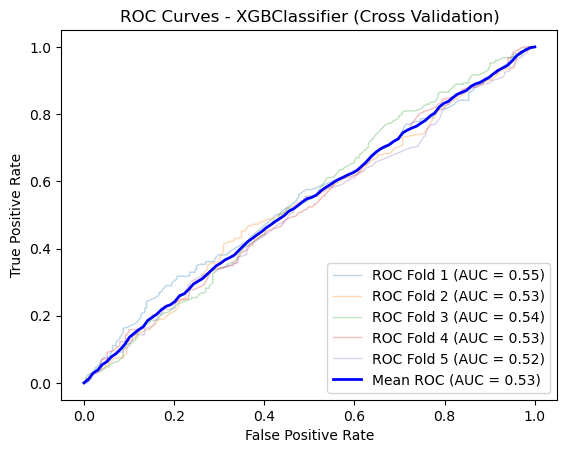


Results for XGBClassifier - Testing:
Accuracy: 0.5873015873015873

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.58      0.58       315
           1       0.59      0.59      0.59       315

    accuracy                           0.59       630
   macro avg       0.59      0.59      0.59       630
weighted avg       0.59      0.59      0.59       630

Precision for Class 0: 0.5884244372990354
Recall for Class 0: 0.580952380952381
F1-Score for Class 0: 0.5846645367412141
Precision for Class 1: 0.5862068965517241
Recall for Class 1: 0.5936507936507937
F1-Score for Class 1: 0.5899053627760252

Matthews Correlation Coefficient: 0.17461725365933756

Test AUC Score: 0.6072058453010833


In [23]:
xgboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)

In [30]:
svm_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
random_forest_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
adaboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
xgboost_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)
extratrees_classifier(scaled_X_train, y_train_data, scaled_X_test, y_test_data, cv, save_auroc=True)


KeyboardInterrupt

